# Data Exploration and Preprocessing

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.layers import Normalization, RandomFlip, RandomRotation, RandomZoom
from PIL import Image

In order to be sure all images are the same size I resized them to 128 by 128. The dataset claimed all images were already sized, however I decided it makes sense to be sure.

In [42]:
# Load in paths
train_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/machine-learning-final/PandasBears/Test"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/machine-learning-final/PandasBears/Train"

img_size = 128    # Image resize for more managable
batch_size = 32   # Number of images per batch

# Load in training dataset
train = tf. keras.preprocessing.image_dataset_from_directory(
            train_dir,
            image_size=(img_size, img_size),
            shuffle=True,
            batch_size=batch_size)

# Load in testing dataset
test = tf. keras.preprocessing.image_dataset_from_directory(
            test_dir,
            image_size=(img_size, img_size),
            shuffle=True,
            batch_size=batch_size)

Found 100 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


The PandasBears dataset contains 640 images in 2 classes. The data is first split by training and testing data with 128 training images and 512 testing images.

In [43]:
# Get the total number of images and classes
num_classes = len(train.class_names)
class_names = train.class_names

total_training_images = tf.data.experimental.cardinality(train).numpy() * batch_size  # Total images in training dataset
total_testing_images = tf.data.experimental.cardinality(test).numpy() * batch_size  # Total images in testing dataset
total_images = total_training_images + total_testing_images  # Total images in dataset

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}\n")
print(f"Total training images: {total_training_images}")
print(f"Total testing images: {total_testing_images}")
print(f"Total images: {total_images}")

Number of classes: 2
Class names: ['Bears', 'Pandas']

Total training images: 128
Total testing images: 512
Total images: 640


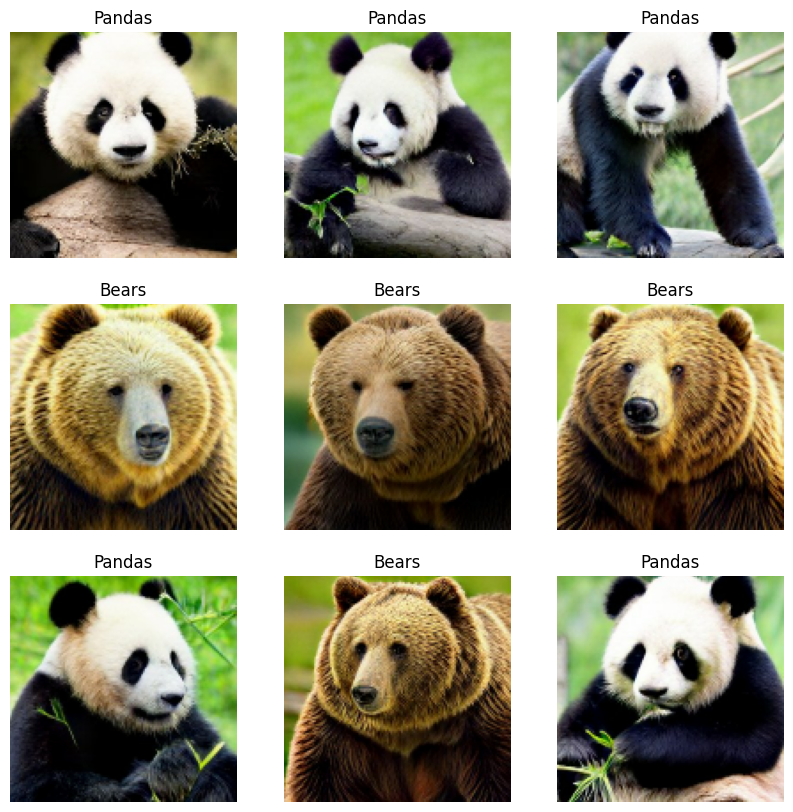

In [44]:
# Display a few sample images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train.class_names[labels[i]])
        plt.axis("off")
plt.show()

The distribution of pandas vs bears is a perfect split of 50 - 50. This means 64 each in the training and 256 each in the testing. Since there is no imbalance in my dataset I do not need to worry about frequency of images causing underfitting or overfitting.


In [45]:
# Get the class distribution (number of images per class)
class_counts = {}
for images, labels in train:
    for label in labels.numpy():
        class_counts[train.class_names[label]] = class_counts.get(train.class_names[label], 0) + 1

print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Class Distribution:
Pandas: 50
Bears: 50


Checking for missing or corrupted images showed no corrupted images for either dataset. I did this by attempting to load each image, if it doesn't load it is corrupted.


In [46]:
def check_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()  # Verify that the image is not corrupted
        return True
    except (IOError, SyntaxError) as e:
        print(f"Corrupted image file: {file_path}")
        return False

# Testing the train set
for root, dirs, files in os.walk(train_dir):
    for file in files:
        file_path = os.path.join(root, file)
        check_image(file_path)

# Testing the test set
for root, dirs, files in os.walk(test_dir):
    for file in files:
        file_path = os.path.join(root, file)
        check_image(file_path)


On average the brighness of our images are dark, but not extremely. Our mean pixel value of 101.7 indicates this, with values ranging from 0 (black) to 255 (white) it is evident our pictures are more black than white.

The standard deviation of 81.17 measures the spread/variation of pixel values around the mean. 81.17 suggests there is a significant amount of variation in the pixel values so our images have a decent amount of contrast and detail.

In [47]:
# Calculate and display some basic image statistics (mean, standard deviation)
image_list = []
for images, labels in train:
    for image in images.numpy():
        image_list.append(image)

all_images = np.array(image_list)

# Average brightness or intesisty of the images
print(f"Mean pixel value: {np.mean(all_images)}")

# Variations of spread pixel values around the mean, higher = more contrast and variation
print(f"Standard deviation of pixel values: {np.std(all_images)}")

# Store these values in variables
mean_pixel_value = np.mean(all_images)
std_pixel_value = np.std(all_images)

Mean pixel value: 101.69316101074219
Standard deviation of pixel values: 81.1673355102539


It is a common technique to use the mean and standard deviation values to normalize a dataset. To do this I use the same values for both the training and testing dataset to ensure consistency. Normalization can significantly improve the performance of my model. The normilization being added to the model is not shown here as it is best to use it as a layer in our model. For example, I will do something like below:

```
# Build your model
model = tf.keras.Sequential([
    normalization_layer,  # Add the normalization layer as the first layer
    # .. the rest of the layers
])

```
First I need to specify my layer though, this is shown below.

In [48]:
# Create a Normalization layer
normalization_layer = Normalization()

# Adapt the layer to your data
normalization_layer.adapt(train.map(lambda x, _: x))

I will also add a layer for data augmentation. This will expand the diversity of my dataset by applying various transformations. Since our dataset size is not very large (as discussed above), this is an important step in providing the model with more examples to learn from. It also reduces the models chances of overfitting and increases models robustness. This step will hoepfully make the model have better performance.

In [50]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),  # Flips images horizontally
    RandomRotation(0.2),  # Rotates images by up to 20%
    RandomZoom(0.2),  # Zooms images by up to 20%
])

The step below optimizes the data pipeline. The `cache()` operation caches this dataset in memory so it can be loaded faster. The `shuffle()` operation shuffles the elements using a buffer of the specified size, this helps with randomixation. The `prefetch()` operation fetches the elements of the datset in the background.

In [49]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)